In [1]:
import time
import copy

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torch.utils.data.dataset import random_split
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import numpy as np

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
num_epochs = 5
num_classes = 10
batch_size = 128
learning_rate = 0.001

In [4]:
torch.manual_seed(0)

def normalize(data_tensor):
    '''re-scale image values to [-1, 1]'''
    return (data_tensor / 255.) * 2. - 1.


def tile_image(image):
    '''duplicate along channel axis'''
    return image.repeat(3, 1, 1)


transform_list = [transforms.ToTensor(
), transforms.Lambda(lambda x: normalize(x))]

train_dataset = torchvision.datasets.MNIST(root='data',
                                           train=True,
                                           transform=transforms.Compose(transform_list+[
                                               transforms.ToPILImage(),
                                               transforms.ToTensor(),
                                               ]),
                                           download=True)


test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False,
                                          transform=transforms.Compose(transform_list+[
                                              transforms.ToPILImage(),
                                              transforms.ToTensor(),
                                              
                                          ]))

# Before
print('Train data set:', len(train_dataset))
print('Test data set:', len(test_dataset))

# Random split
train_set_size = int(len(train_dataset) * 0.8)
indices = list(range(train_set_size))
split = int(np.floor(.2 * train_set_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler =  SequentialSampler(val_indices)
   

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=train_sampler,
                                           batch_size=batch_size,
                                           )

valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           sampler=valid_sampler,
                                           batch_size=batch_size,
                                           )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=1,
                                          shuffle=False)

Train data set: 60000
Test data set: 10000


In [5]:
dataiter = iter(train_loader) # creating a iterator
images, labels = dataiter.next() # creating images for image and lables for image number (0 to 9) 

print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


In [6]:
class NeuralNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, act_func=nn.Sigmoid()):
        super(NeuralNet, self).__init__()
        layers = []
        layers.append(nn.Linear(in_channels, hidden_channels[0])) # This the first layer [in_channels, hidden_channels[0]]. For example in this exercise: in 784, out 300
        layers.append(act_func) # activation function
        # Hidden layers
        for i in range(1, len(hidden_channels)): 
            layers.append(nn.Linear(hidden_channels[i-1], hidden_channels[i]))
            layers.append(act_func) # activation function
        # 300, 200
        # sigmoid
        # 200, 100
        # sigmoid
        layers.append(nn.Linear(hidden_channels[-1], out_channels)) # This is the last layers [hidden_channels[-1], out_channels]. For example in this exercise: in 100, out 10
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [7]:
model = NeuralNet(in_channels=1*28*28, hidden_channels=[300, 200, 100], out_channels=10).to(device)
model

NeuralNet(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=300, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [8]:
def train_val_model(model, criterion, optimizer, dataloaders, num_epochs=25,
        scheduler=None, log_interval=None):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Store losses and accuracies accross epochs
    losses, accuracies = dict(train=[], val=[]), dict(train=[], val=[])

    for epoch in range(num_epochs):
        if log_interval is not None and epoch % log_interval == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            nsamples = 0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.reshape(-1, 1*28*28).to(device)
                labels = labels.to(device)
                nsamples += inputs.shape[0]

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if scheduler is not None and phase == 'train':
                scheduler.step()

            #nsamples = dataloaders[phase].dataset.data.shape[0]
            epoch_loss = running_loss / nsamples
            epoch_acc = running_corrects.double() / nsamples

            losses[phase].append(epoch_loss)
            accuracies[phase].append(epoch_acc)
            if log_interval is not None and epoch % log_interval == 0:
                print('{} Loss: {:.4f} Acc: {:.5f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        if log_interval is not None and epoch % log_interval == 0:
            print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.5f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, losses, accuracies

Total number of parameters = 316810
Epoch 0/9
----------
train Loss: 2.3047 Acc: 0.10776
val Loss: 2.3014 Acc: 0.11333

Epoch 1/9
----------
train Loss: 2.0109 Acc: 0.23932
val Loss: 1.7446 Acc: 0.30750

Epoch 2/9
----------
train Loss: 1.6022 Acc: 0.37922
val Loss: 1.3742 Acc: 0.47906

Epoch 3/9
----------
train Loss: 1.2793 Acc: 0.50305
val Loss: 1.1962 Acc: 0.52958

Epoch 4/9
----------
train Loss: 1.1773 Acc: 0.54643
val Loss: 1.1225 Acc: 0.55833

Epoch 5/9
----------
train Loss: 1.1044 Acc: 0.58167
val Loss: 1.0552 Acc: 0.60229

Epoch 6/9
----------
train Loss: 1.0145 Acc: 0.63547
val Loss: 0.9150 Acc: 0.69000

Epoch 7/9
----------
train Loss: 0.8517 Acc: 0.71154
val Loss: 0.7909 Acc: 0.73073

Epoch 8/9
----------
train Loss: 0.7549 Acc: 0.74495
val Loss: 0.7143 Acc: 0.75583

Epoch 9/9
----------
train Loss: 0.7154 Acc: 0.76174
val Loss: 0.6984 Acc: 0.76552

Training complete in 2m 0s
Best val Acc: 0.76552


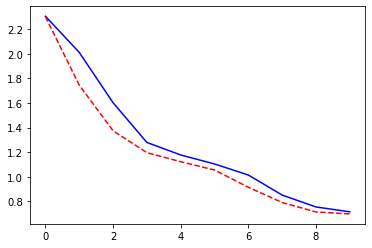

In [9]:
criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=.9, nesterov=True)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

dataloaders = dict(train=train_loader, val=valid_loader)

print("Total number of parameters =", np.sum([np.prod(parameter.shape) for parameter in model.parameters()]))

model, losses, accuracies = train_val_model(model, criterion, optimizer, dataloaders, num_epochs=10, log_interval=1)

_ = plt.plot(losses['train'], '-b', losses['val'], '--r')

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 1*28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: {:.5f} '.format(correct / total))

Accuracy of the network on the 10000 test images: 0.76300 
